<a href="https://colab.research.google.com/github/MilburnJ/SeafloorSegmentation/blob/main/Seafloor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# import the necessary packages
import torch
import os
# base path of the dataset
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join("/content/drive/MyDrive/", "seafloor_images")
MASK_DATASET_PATH = os.path.join("/content/drive/MyDrive/", "seafloor_masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [ ]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 3
NUM_CLASSES = 17
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0001
NUM_EPOCHS = 50
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 224
INPUT_IMAGE_HEIGHT = 224
# define threshold to filter weak predictions
THRESHOLD = 0.3
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/seafloor_output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "seafloor-segment.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [ ]:
sediment_colors = {
    'S': (255, 255, 0),  # Yellow for Sand
    'G': (128, 0, 128),   # Purple for Gravel
    'R': (128, 128, 128), # Gray for Rock
    'M': (0, 0, 255),     # Blue for Mud
    'Sg': (255, 165, 0),  # Orange for Sand and Gravel
    'Sr': (255, 192, 203),# Pink for Sand and Rock
    'Sm': (0, 255, 255),  # Cyan for Sand and Mud
    'Gs': (0, 255, 0),    # Green for Gravel and Sand
    'Gr': (255, 0, 0),    # Red for Gravel and Rock
    'Gm': (255, 69, 0),   # Orange-Red for Gravel and Mud
    'Ms': (0, 128, 128),  # Teal for Mud and Sand
    'Mg': (0, 255, 128),  # Bluish-Green for Mud and Gravel
    'Mr': (128, 0, 0),    # Maroon for Mud and Rock
    'Rs': (192, 192, 192),# Light Gray for Rock and Sand
    'Rg': (128, 0, 255),  # Purple-Blue for Rock and Gravel
    'Rm': (0, 0, 128),    # Navy for Rock and Mud
}


VOC_COLORMAP = [[255, 255, 0],[128, 0, 128], [128, 128, 128], [0, 0, 255],
                [255, 165, 0], [255, 192, 203], [0, 255, 255], [0, 255, 0],
                [255, 0, 0], [255, 69, 0], [0, 128, 128], [0, 255, 128],
                [128, 0, 0], [192, 192, 192], [128, 0, 255], [0, 0, 128]]


VOC_CLASSES = ['Sand', 'Gravel', 'Rock', 'Mud',
               'Sand-gravel', 'Sand-rock', 'Sand-mud', 'Gravel-sand', 'Gravel-rock', 'Gravel-mud',
               'Mud-Sand', 'Mud-gravel', 'Mud-rock', 'Rock-sand', 'Rock-gravel',
               'Rock-mud',]

def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def voc_label_to_rgb(label_indices, voc_colormap):
    """Convert class indices to RGB images using the VOC colormap."""
    rgb_image = np.zeros((label_indices.shape[0], label_indices.shape[1], 3), dtype=np.uint8)
    for idx, rgb in enumerate(voc_colormap):
        rgb_image[label_indices == idx] = rgb
    return rgb_image

def class_map_to_one_hot(class_map, num_classes):
    """
    Convert class map to one-hot encoded tensor.

    Args:
        class_map (torch.Tensor): Class map with class indices. Shape: (height, width).
        num_classes (int): Number of classes.

    Returns:
        torch.Tensor: One-hot encoded tensor of shape (num_classes, height, width).
    """
    height, width = class_map.size()
    one_hot_map = torch.zeros(num_classes, height, width, dtype=torch.float32)
    for class_index in range(num_classes):
        one_hot_map[class_index, :, :] = (class_map == class_index).type(torch.float32)
    return one_hot_map

In [ ]:
from PIL import Image
import numpy as np
import torchvision.io

test = torchvision.io.read_image(MASK_DATASET_PATH+'/patch_3584_2432.png')
#test = cv2.imread(MASK_DATASET_PATH+'/patch_3584_3584.png')
#test = Image.fromarray(np.uint8(test))
y = voc_label_indices(test, voc_colormap2label())
print(y.shape)
print(y)
y = class_map_to_one_hot(y, 16)
print(y.shape)
print(y[11])


torch.Size([256, 256])
tensor([[0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        [0, 0, 0,  ..., 2, 2, 2],
        ...,
        [4, 4, 4,  ..., 2, 2, 2],
        [4, 4, 4,  ..., 2, 2, 2],
        [4, 4, 4,  ..., 2, 2, 2]])
torch.Size([16, 256, 256])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 68.0 MB/s eta 0:00:00


In [ ]:
# import the necessary packages
from torch.utils.data import Dataset
#import rasterio
from tifffile import imread
import cv2
import numpy as np
from torchvision.transforms import ToTensor
import skimage.transform
from scipy.interpolate import griddata

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		self.colormap2label = voc_colormap2label()

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]



		#image = rasterio.open(imagePath)
		#image = image.read()
		image= skimage.io.imread(imagePath)
		image = skimage.transform.resize(image,(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT))

		image = ToTensor()(image)
		#Put NORMALIZE here
		#Maximum value of bathy_image: 23.580292
		#after removing min value is -88.83606719970703
		image[0] = (image[0]/255)
		image[1] = ((image[1] - 23.580292) / (-88.83606719970703 - 23.580292))
		three_chan_image = torch.stack((image[0],image[1],image[2]))
		#replace all values of 1 in bathymetry to stop gradient explosion

		#combinedImage = torch.add(image[0],image[1])
		mask = torchvision.io.read_image(self.maskPaths[idx])
		mask = torchvision.transforms.Resize((INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT))(mask)


		#mask = voc_label_indices(mask, self.colormap2label)

		#print(mask[40:50, 110:120])
		#if self.transforms is not None:
			# apply the transformations to both image and its mask
			#image = self.transforms(image)
			#mask = self.transforms(mask)
		# return a tuple of the image and its mask
		mask = voc_label_indices(mask, self.colormap2label)
		#mask = class_map_to_one_hot(mask, 16)

		return (three_chan_image, mask)

In [ ]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [ ]:
# import the necessary packages
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [ ]:
import os

# Function to remove files with (1) in their filenames
def remove_files_with_1(directory):
    for filename in os.listdir(directory):
        if "(1)" in filename:
            filepath = os.path.join(directory, filename)
            os.remove(filepath)
            print(f"Removed file: {filepath}")

# Remove files with (1) from the image directory
remove_files_with_1(IMAGE_DATASET_PATH)

# Remove files with (1) from the mask directory
remove_files_with_1(MASK_DATASET_PATH)

In [ ]:


# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
print("Number of image files:", len(imagePaths))
print("Number of mask files:", len(maskPaths))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

Number of image files: 5972
Number of mask files: 5972
[INFO] saving testing image paths...


In [ ]:
from torchvision import transforms
# define transformations
transforms = transforms.Compose([#transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT,
		INPUT_IMAGE_WIDTH)),
	])#transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=4)#os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
	num_workers=4)#os.cpu_count())

[INFO] found 5076 examples in the training set...
[INFO] found 896 examples in the test set...


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.nn import functional as F


In [ ]:
def get_backbone(name, pretrained=True,input_channels=3):

    """ Loading backbone, defining names for skip-connections and encoder output. """

    # TODO: More backbones

    # loading backbone model
    if name == 'resnet18':
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    elif name == 'resnet34':
        backbone = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    elif name == 'resnet50':
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    elif name == 'resnet101':
        backbone = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
    elif name == 'resnet152':
        backbone = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    elif name == 'vgg16':
        backbone = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
    elif name == 'vgg19':
        backbone = models.vgg19_bn(weights=models.VGG19_BN_Weights.IMAGENET1K_V1).features
    elif name == 'densenet121':
        backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).features
    elif name == 'densenet161':
        backbone = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1).features
    elif name == 'densenet169':
        backbone = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1).features
    elif name == 'densenet201':
        backbone = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1).features
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    """
     # Modify the initial convolutional layer to accept input_channels
    if name.startswith('resnet'):
        if input_channels != 3:
            backbone.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(7,7), stride=2, padding=0, bias=False)
    elif name.startswith('vgg'):
        if input_channels != 3:
            backbone[0] = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
    elif name.startswith('densenet'):
        if input_channels != 3:
            backbone.conv0 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    """


    # specifying skip feature and output names
    if name.startswith('resnet'):
        feature_names = [None, 'relu', 'layer1', 'layer2', 'layer3']
        backbone_output = 'layer4'
    elif name == 'vgg16':
        # TODO: consider using a 'bridge' for VGG models, there is just a MaxPool between last skip and backbone output
        feature_names = ['5', '12', '22', '32', '42']
        backbone_output = '43'
    elif name == 'vgg19':
        feature_names = ['5', '12', '25', '38', '51']
        backbone_output = '52'
    # elif name == 'inception_v3':
    #     feature_names = [None, 'Mixed_5d', 'Mixed_6e']
    #     backbone_output = 'Mixed_7c'
    elif name.startswith('densenet'):
        feature_names = [None, 'relu0', 'denseblock1', 'denseblock2', 'denseblock3']
        backbone_output = 'denseblock4'
    elif name == 'unet_encoder':
        feature_names = ['module1', 'module2', 'module3', 'module4']
        backbone_output = 'module5'
    else:
        raise NotImplemented('{} backbone model is not implemented so far.'.format(name))

    return backbone, feature_names, backbone_output



In [ ]:

class UpsampleBlock(nn.Module):

    # TODO: separate parametric and non-parametric classes?
    # TODO: skip connection concatenated OR added

    def __init__(self, ch_in, ch_out=None, skip_in=0, use_bn=True, parametric=False):
        super(UpsampleBlock, self).__init__()

        self.parametric = parametric
        ch_out = ch_in/2 if ch_out is None else ch_out

        # first convolution: either transposed conv, or conv following the skip connection
        if parametric:
            # versions: kernel=4 padding=1, kernel=2 padding=0
            self.up = nn.ConvTranspose2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(4, 4),
                                         stride=2, padding=1, output_padding=0, bias=(not use_bn))
            self.bn1 = nn.BatchNorm2d(ch_out) if use_bn else None
        else:
            self.up = None
            ch_in = ch_in + skip_in
            self.conv1 = nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=(3, 3),
                                   stride=1, padding=1, bias=(not use_bn))
            self.bn1 = nn.BatchNorm2d(ch_out) if use_bn else None

        self.relu = nn.ReLU(inplace=True)

        # second convolution
        conv2_in = ch_out if not parametric else ch_out + skip_in
        self.conv2 = nn.Conv2d(in_channels=conv2_in, out_channels=ch_out, kernel_size=(3, 3),
                               stride=1, padding=1, bias=(not use_bn))
        self.bn2 = nn.BatchNorm2d(ch_out) if use_bn else None
    def forward(self, x, skip_connection=None):

        x = self.up(x) if self.parametric else F.interpolate(x, size=None, scale_factor=2, mode='bilinear',
                                                             align_corners=None)
        if self.parametric:
            x = self.bn1(x) if self.bn1 is not None else x
            x = self.relu(x)

        if skip_connection is not None:
            x = torch.cat([x, skip_connection], dim=1)

        if not self.parametric:
            x = self.conv1(x)
            x = self.bn1(x) if self.bn1 is not None else x
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.bn2 is not None else x
        x = self.relu(x)

        return x



In [ ]:

class Unet(nn.Module):

    """ U-Net (https://arxiv.org/pdf/1505.04597.pdf) implementation with pre-trained torchvision backbones."""

    def __init__(self,
                 backbone_name='resnet50',
                 pretrained=True,
                 encoder_freeze=False,
                 classes=16,
                 input_channels=3,
                 decoder_filters=(256, 128, 64, 32, 16),
                 parametric_upsampling=True,
                 shortcut_features='default',
                 decoder_use_batchnorm=True):
        super(Unet, self).__init__()

        self.backbone_name = backbone_name

        self.backbone, self.shortcut_features, self.bb_out_name = get_backbone(backbone_name, pretrained=pretrained,input_channels=input_channels)
        shortcut_chs, bb_out_chs = self.infer_skip_channels()
        if shortcut_features != 'default':
            self.shortcut_features = shortcut_features

        # build decoder part
        self.upsample_blocks = nn.ModuleList()
        decoder_filters = decoder_filters[:len(self.shortcut_features)]  # avoiding having more blocks than skip connections
        decoder_filters_in = [bb_out_chs] + list(decoder_filters[:-1])
        num_blocks = len(self.shortcut_features)
        for i, [filters_in, filters_out] in enumerate(zip(decoder_filters_in, decoder_filters)):
            print('upsample_blocks[{}] in: {}   out: {}'.format(i, filters_in, filters_out))
            self.upsample_blocks.append(UpsampleBlock(filters_in, filters_out,
                                                      skip_in=shortcut_chs[num_blocks-i-1],
                                                      parametric=parametric_upsampling,
                                                      use_bn=decoder_use_batchnorm))

        self.final_conv = nn.Conv2d(decoder_filters[-1], classes, kernel_size=(1, 1))

        if encoder_freeze:
            self.freeze_encoder()

        self.replaced_conv1 = True  # for accommodating  inputs with different number of channels later

    def freeze_encoder(self):

        """ Freezing encoder parameters, the newly initialized decoder parameters are remaining trainable. """

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, *input):

        """ Forward propagation in U-Net. """

        x, features = self.forward_backbone(*input)

        for skip_name, upsample_block in zip(self.shortcut_features[::-1], self.upsample_blocks):
            skip_features = features[skip_name]
            x = upsample_block(x, skip_features)

        x = self.final_conv(x)
        return x

    def forward_backbone(self, x):

        """ Forward propagation in backbone encoder network.  """

        features = {None: None} if None in self.shortcut_features else dict()
        for name, child in self.backbone.named_children():
            x = child(x)
            if name in self.shortcut_features:
                features[name] = x
            if name == self.bb_out_name:
                break

        return x, features

    def infer_skip_channels(self):

        """ Getting the number of channels at skip connections and at the output of the encoder. """
        #Change this based on image size and num channels
        x = torch.zeros(1, 3, 224, 224)
        has_fullres_features = self.backbone_name.startswith('vgg') or self.backbone_name == 'unet_encoder'
        channels = [] if has_fullres_features else [0]  # only VGG has features at full resolution

        # forward run in backbone to count channels (dirty solution but works for *any* Module)
        for name, child in self.backbone.named_children():
            x = child(x)
            if name in self.shortcut_features:
                channels.append(x.shape[1])
            if name == self.bb_out_name:
                out_channels = x.shape[1]
                break
        return channels, out_channels

    def get_pretrained_parameters(self):
        for name, param in self.backbone.named_parameters():
            if not (self.replaced_conv1 and name == 'conv1.weight'):
                yield param

    def get_random_initialized_parameters(self):
        pretrained_param_names = set()
        for name, param in self.backbone.named_parameters():
            if not (self.replaced_conv1 and name == 'conv1.weight'):
                pretrained_param_names.add('backbone.{}'.format(name))

        for name, param in self.named_parameters():
            if name not in pretrained_param_names:
                yield param


In [ ]:
from sklearn.utils.class_weight import compute_class_weight



first_indices = [element[1].clone().numpy() for element in trainDS]
first_indices = np.array(first_indices)
#print(first_indices[0])
# Flatten the list of arrays
first_indices_flat = first_indices.flatten()

# Get unique classes
unique_classes = np.unique(first_indices_flat)
print(unique_classes)
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=first_indices_flat)

print(weights)

[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16]
[1.73649567e+00 2.63782048e-01 3.42543436e+02 1.99913295e+00
 4.79481773e-01 4.98940143e+00 3.22457003e-01 1.20383568e+00
 1.61160770e+00 5.84865250e+01 6.09375479e-01 3.58787748e+01
 5.30268293e+01 5.18540612e+00 4.54413533e-01 5.17416728e+00]


In [ ]:
weight_array = np.insert(weights,4,0.001)
print(weight_array)
weight_array = torch.tensor(weight_array, dtype=torch.float)
print(weight_array)
weight_array = weight_array.to(device='cuda')

[1.73649567e+00 2.63782048e-01 3.42543436e+02 1.99913295e+00
 1.00000000e-03 4.79481773e-01 4.98940143e+00 3.22457003e-01
 1.20383568e+00 1.61160770e+00 5.84865250e+01 6.09375479e-01
 3.58787748e+01 5.30268293e+01 5.18540612e+00 4.54413533e-01
 5.17416728e+00]
tensor([1.7365e+00, 2.6378e-01, 3.4254e+02, 1.9991e+00, 1.0000e-03, 4.7948e-01,
        4.9894e+00, 3.2246e-01, 1.2038e+00, 1.6116e+00, 5.8487e+01, 6.0938e-01,
        3.5879e+01, 5.3027e+01, 5.1854e+00, 4.5441e-01, 5.1742e+00])


In [ ]:
torch.cuda.empty_cache()

In [ ]:



# initialize our UNet model
unet = Unet(backbone_name="resnet18",
            pretrained=True,
            encoder_freeze=False,
            classes=16,
            input_channels=3,
            decoder_filters=(256, 128, 64, 32, 16),
            parametric_upsampling=True,
            shortcut_features='default',
            decoder_use_batchnorm=True).to(DEVICE)

# initialize loss function and optimizer
lossFunc = CrossEntropyLoss(weight=weight_array)
opt = Adam(unet.parameters(), lr=INIT_LR)
scheduler = lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_EPOCHS*len(trainLoader), eta_min=0.00001, last_epoch=-1)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


[INFO] training the network...


  2%|▏         | 1/50 [01:49<1:29:48, 109.98s/it]

[INFO] EPOCH: 1/50
Train loss: 2.512152, Test loss: 2.0143


  4%|▍         | 2/50 [02:57<1:07:51, 84.82s/it] 

[INFO] EPOCH: 2/50
Train loss: 1.995363, Test loss: 1.7275


  6%|▌         | 3/50 [04:04<1:00:11, 76.84s/it]

[INFO] EPOCH: 3/50
Train loss: 1.629084, Test loss: 1.3823


  8%|▊         | 4/50 [05:10<55:43, 72.68s/it]  

[INFO] EPOCH: 4/50
Train loss: 1.337752, Test loss: 1.2308


 10%|█         | 5/50 [06:18<53:01, 70.71s/it]

[INFO] EPOCH: 5/50
Train loss: 1.166274, Test loss: 1.0737


 12%|█▏        | 6/50 [07:24<50:54, 69.42s/it]

[INFO] EPOCH: 6/50
Train loss: 1.039412, Test loss: 0.9371


 14%|█▍        | 7/50 [08:31<49:04, 68.48s/it]

[INFO] EPOCH: 7/50
Train loss: 0.942374, Test loss: 0.8795


 16%|█▌        | 8/50 [09:38<47:39, 68.09s/it]

[INFO] EPOCH: 8/50
Train loss: 0.852910, Test loss: 0.7719


 18%|█▊        | 9/50 [10:45<46:15, 67.69s/it]

[INFO] EPOCH: 9/50
Train loss: 0.762570, Test loss: 0.6874


 20%|██        | 10/50 [11:51<44:48, 67.21s/it]

[INFO] EPOCH: 10/50
Train loss: 0.704754, Test loss: 0.6456


 22%|██▏       | 11/50 [12:58<43:35, 67.06s/it]

[INFO] EPOCH: 11/50
Train loss: 0.632959, Test loss: 0.5800


 24%|██▍       | 12/50 [14:05<42:25, 67.00s/it]

[INFO] EPOCH: 12/50
Train loss: 0.575275, Test loss: 0.5204


 26%|██▌       | 13/50 [15:12<41:17, 66.96s/it]

[INFO] EPOCH: 13/50
Train loss: 0.523013, Test loss: 0.4830


 28%|██▊       | 14/50 [16:19<40:14, 67.08s/it]

[INFO] EPOCH: 14/50
Train loss: 0.476785, Test loss: 0.4386


 30%|███       | 15/50 [17:26<39:08, 67.11s/it]

[INFO] EPOCH: 15/50
Train loss: 0.442988, Test loss: 0.4087


 32%|███▏      | 16/50 [18:33<37:53, 66.88s/it]

[INFO] EPOCH: 16/50
Train loss: 0.406634, Test loss: 0.3725


 34%|███▍      | 17/50 [19:40<36:48, 66.94s/it]

[INFO] EPOCH: 17/50
Train loss: 0.374302, Test loss: 0.3412


 36%|███▌      | 18/50 [20:48<35:51, 67.24s/it]

[INFO] EPOCH: 18/50
Train loss: 0.346636, Test loss: 0.3125


 38%|███▊      | 19/50 [21:56<34:57, 67.67s/it]

[INFO] EPOCH: 19/50
Train loss: 0.322947, Test loss: 0.2963


 40%|████      | 20/50 [23:05<33:56, 67.89s/it]

[INFO] EPOCH: 20/50
Train loss: 0.300460, Test loss: 0.2754


 42%|████▏     | 21/50 [24:12<32:44, 67.73s/it]

[INFO] EPOCH: 21/50
Train loss: 0.277873, Test loss: 0.2557


 44%|████▍     | 22/50 [25:20<31:37, 67.77s/it]

[INFO] EPOCH: 22/50
Train loss: 0.263096, Test loss: 0.2462


 46%|████▌     | 23/50 [26:27<30:27, 67.67s/it]

[INFO] EPOCH: 23/50
Train loss: 0.248179, Test loss: 0.2271


 48%|████▊     | 24/50 [27:36<29:23, 67.84s/it]

[INFO] EPOCH: 24/50
Train loss: 0.232915, Test loss: 0.2170


 50%|█████     | 25/50 [28:43<28:10, 67.63s/it]

[INFO] EPOCH: 25/50
Train loss: 0.220816, Test loss: 0.2070


 52%|█████▏    | 26/50 [29:50<26:58, 67.44s/it]

[INFO] EPOCH: 26/50
Train loss: 0.209955, Test loss: 0.2019


 54%|█████▍    | 27/50 [30:57<25:50, 67.41s/it]

[INFO] EPOCH: 27/50
Train loss: 0.197694, Test loss: 0.1913


 56%|█████▌    | 28/50 [32:05<24:44, 67.47s/it]

[INFO] EPOCH: 28/50
Train loss: 0.190034, Test loss: 0.1845


 58%|█████▊    | 29/50 [33:11<23:30, 67.15s/it]

[INFO] EPOCH: 29/50
Train loss: 0.181069, Test loss: 0.1750


 60%|██████    | 30/50 [34:19<22:26, 67.32s/it]

[INFO] EPOCH: 30/50
Train loss: 0.175029, Test loss: 0.1690


 62%|██████▏   | 31/50 [35:26<21:17, 67.22s/it]

[INFO] EPOCH: 31/50
Train loss: 0.167993, Test loss: 0.1662


 64%|██████▍   | 32/50 [36:33<20:10, 67.23s/it]

[INFO] EPOCH: 32/50
Train loss: 0.161784, Test loss: 0.1594


 66%|██████▌   | 33/50 [37:39<18:58, 66.98s/it]

[INFO] EPOCH: 33/50
Train loss: 0.157266, Test loss: 0.1534


 68%|██████▊   | 34/50 [38:46<17:51, 66.99s/it]

[INFO] EPOCH: 34/50
Train loss: 0.150070, Test loss: 0.1484


 70%|███████   | 35/50 [39:53<16:45, 67.00s/it]

[INFO] EPOCH: 35/50
Train loss: 0.147105, Test loss: 0.1459


 72%|███████▏  | 36/50 [41:00<15:38, 67.00s/it]

[INFO] EPOCH: 36/50
Train loss: 0.143065, Test loss: 0.1443


 74%|███████▍  | 37/50 [42:08<14:32, 67.10s/it]

[INFO] EPOCH: 37/50
Train loss: 0.139882, Test loss: 0.1384


 76%|███████▌  | 38/50 [43:15<13:25, 67.10s/it]

[INFO] EPOCH: 38/50
Train loss: 0.135952, Test loss: 0.1378


 78%|███████▊  | 39/50 [44:23<12:20, 67.34s/it]

[INFO] EPOCH: 39/50
Train loss: 0.133794, Test loss: 0.1347


 80%|████████  | 40/50 [45:31<11:17, 67.73s/it]

[INFO] EPOCH: 40/50
Train loss: 0.131268, Test loss: 0.1357


 82%|████████▏ | 41/50 [46:40<10:11, 67.89s/it]

[INFO] EPOCH: 41/50
Train loss: 0.127707, Test loss: 0.1305


 84%|████████▍ | 42/50 [47:47<09:01, 67.74s/it]

[INFO] EPOCH: 42/50
Train loss: 0.126225, Test loss: 0.1297


 86%|████████▌ | 43/50 [48:55<07:54, 67.74s/it]

[INFO] EPOCH: 43/50
Train loss: 0.123497, Test loss: 0.1263


 88%|████████▊ | 44/50 [50:02<06:44, 67.45s/it]

[INFO] EPOCH: 44/50
Train loss: 0.122785, Test loss: 0.1252


 90%|█████████ | 45/50 [51:09<05:37, 67.44s/it]

[INFO] EPOCH: 45/50
Train loss: 0.120028, Test loss: 0.1234


 92%|█████████▏| 46/50 [52:17<04:30, 67.62s/it]

[INFO] EPOCH: 46/50
Train loss: 0.119484, Test loss: 0.1261


 94%|█████████▍| 47/50 [53:25<03:22, 67.59s/it]

[INFO] EPOCH: 47/50
Train loss: 0.117701, Test loss: 0.1230


 96%|█████████▌| 48/50 [54:32<02:15, 67.51s/it]

[INFO] EPOCH: 48/50
Train loss: 0.115865, Test loss: 0.1220


 98%|█████████▊| 49/50 [55:39<01:07, 67.46s/it]

[INFO] EPOCH: 49/50
Train loss: 0.114184, Test loss: 0.1203


100%|██████████| 50/50 [56:47<00:00, 68.16s/it]

[INFO] EPOCH: 50/50
Train loss: 0.113618, Test loss: 0.1187
[INFO] total time taken to train the model: 3407.77s


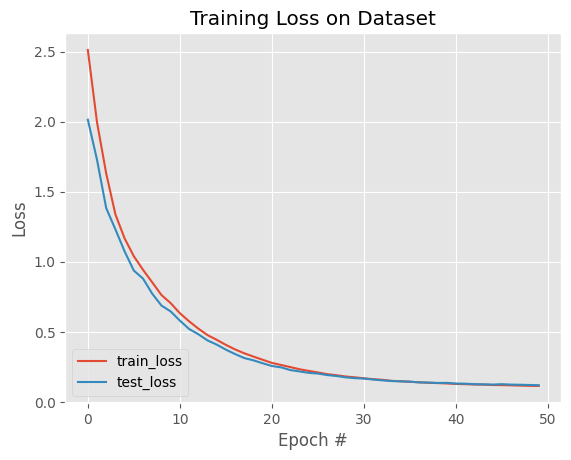

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		scheduler.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [ ]:

# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage[0])
	ax[1].imshow(origMask)
	predMask = np.rot90(predMask)
	predMask = np.rot90(predMask)
	predMask = np.rot90(predMask)
	predMask = np.fliplr(predMask)

	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
import numpy as np
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		#image = cv2.imread(imagePath)
		#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		#image = image.astype("float32") / 255.0


		image= skimage.io.imread(imagePath)
		image = skimage.transform.resize(image,(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT))
		#image = ToTensor()(image)
		orig = image
		orig = np.swapaxes(orig,0,2)
		image = ToTensor()(image)
		image[0] = (image[0]/255)
		image[1] = ((image[1] - 23.580292) / (-88.83606719970703 - 23.580292))
		three_chan_image = torch.stack((image[0],image[1],image[2]))
		print(three_chan_image.shape)
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		gtFilename = filename.replace(".tif",'.png')
		groundTruthPath = os.path.join(MASK_DATASET_PATH,
			gtFilename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		#gtMask = cv2.imread(groundTruthPath)
		gtMask = torchvision.io.read_image(groundTruthPath)
		gtMask = torchvision.transforms.Resize((INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT))(gtMask)

		#gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT,
		#	INPUT_IMAGE_HEIGHT))
		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		#image = np.transpose(image, (2, 0, 1))
		#image = np.swapaxes(image,1,2)
		#three_chan_image = np.swapaxes(three_chan_image,0,2)
		#image = np.expand_dims(image, 0)
		three_chan_image = (three_chan_image).unsqueeze(0).to(DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(three_chan_image).squeeze()
		#predMask = np.swapaxes(predMask,0,2)
  #wdda
#		predMask = torch.sigmoid(predMask)
		predMask = torch.nn.functional.softmax(predMask,dim=0)
		predMask = predMask.argmax(dim=0)
		print(predMask)
		#predMask = predMask.cpu().detach().numpy()
		predMask = predMask.cpu().numpy()

		predMask = voc_label_to_rgb(predMask, VOC_COLORMAP)
		gtMask = np.swapaxes(gtMask,0,2)
		# filter out the weak predictions and convert them to integers
		#predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...
torch.Size([3, 224, 224])
tensor([[ 7,  7,  7,  ..., 14, 14, 14],
        [ 7,  7,  7,  ..., 14, 14, 14],
        [ 7,  7,  7,  ..., 14, 14, 14],
        ...,
        [ 7,  7,  7,  ...,  7,  7,  7],
        [ 7,  7,  7,  ...,  7,  7,  7],
        [ 7,  7,  7,  ...,  7,  7,  7]], device='cuda:0')
torch.Size([3, 224, 224])
tensor([[ 6,  6,  6,  ..., 10, 10, 10],
        [ 6,  6,  6,  ..., 10, 10, 10],
        [ 6,  6,  6,  ..., 10, 10, 10],
        ...,
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10]], device='cuda:0')
torch.Size([3, 224, 224])
tensor([[ 7,  7,  7,  ...,  0,  0,  0],
        [ 7,  7,  7,  ...,  0,  0,  0],
        [ 7,  7,  7,  ...,  0,  0,  0],
        ...,
        [ 8,  8,  8,  ..., 14, 14, 14],
        [ 8,  8,  8,  ..., 14, 14, 14],
        [ 8,  8,  8,  ..., 14, 14, 14]], device='cuda:0')
torch.Size([3, 224, 224])
tensor([[ 0,  0,  0, 

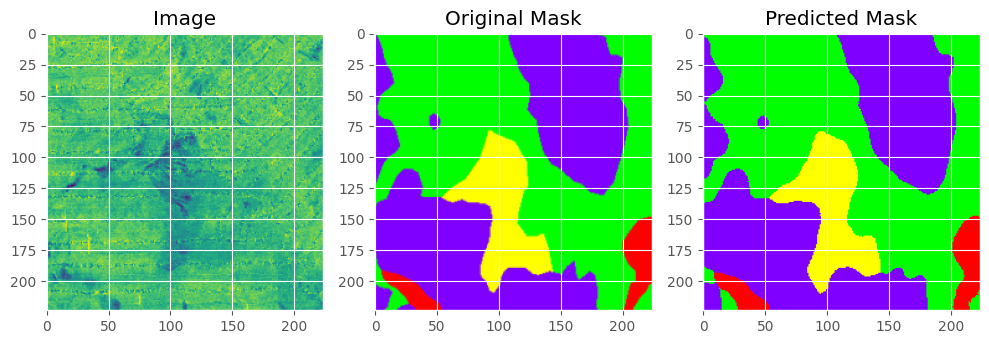

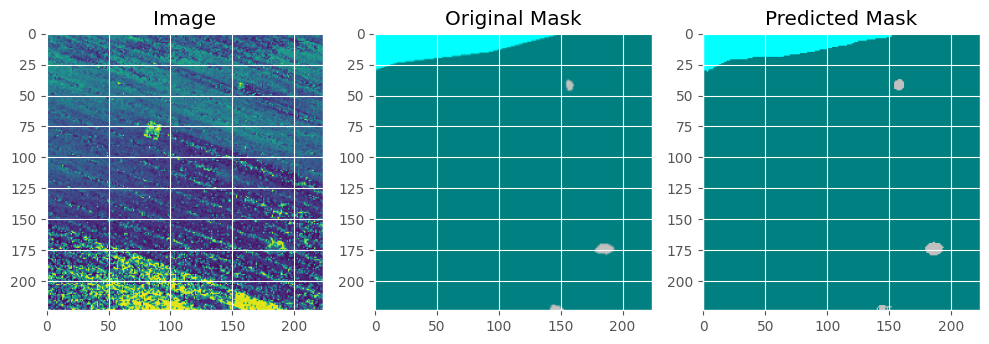

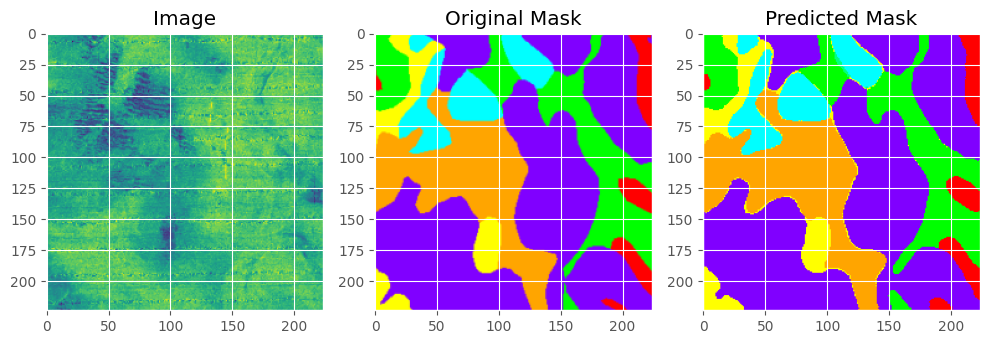

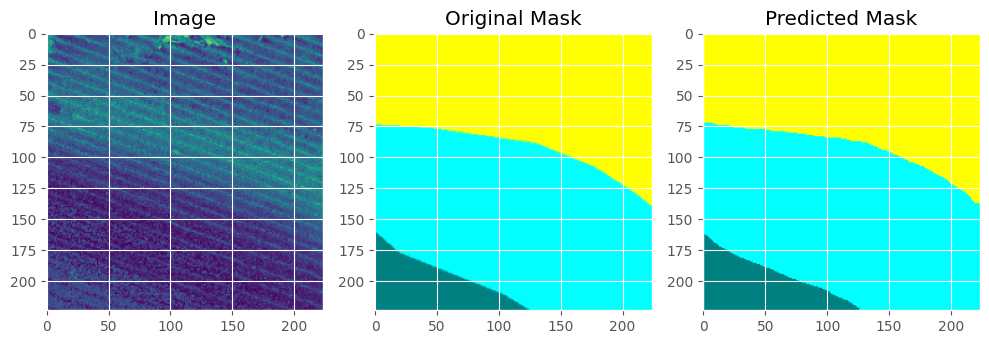

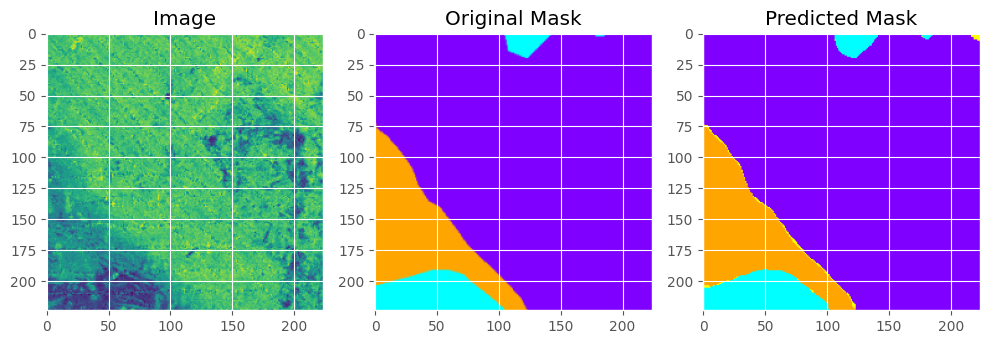

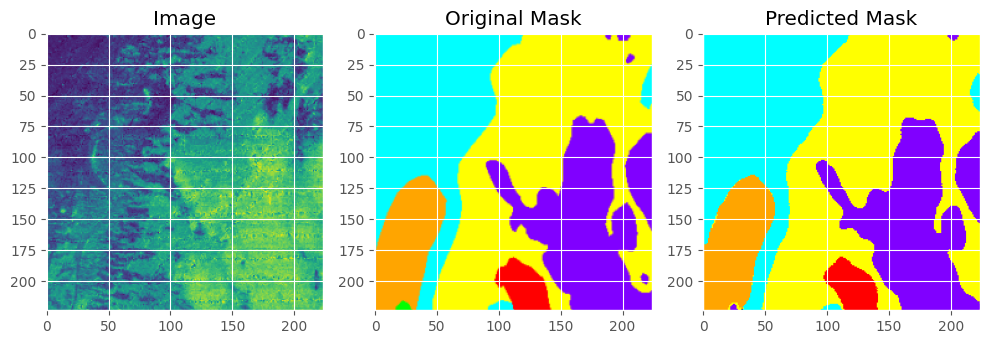

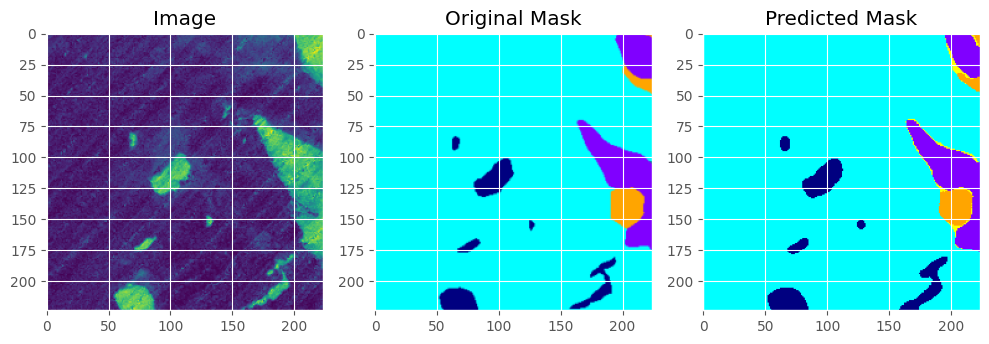

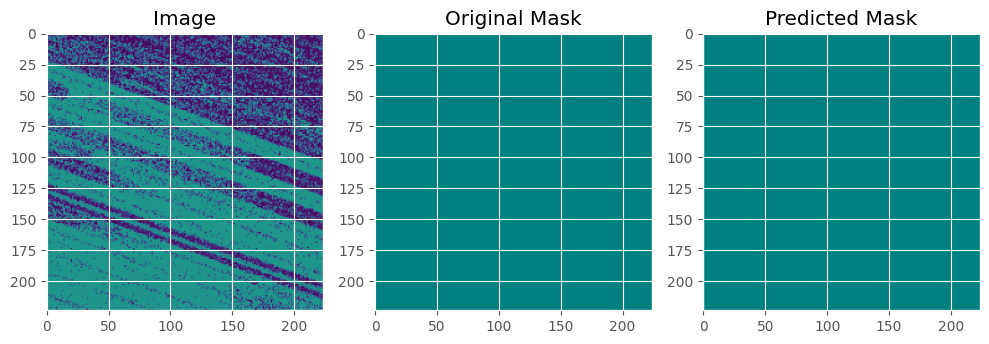

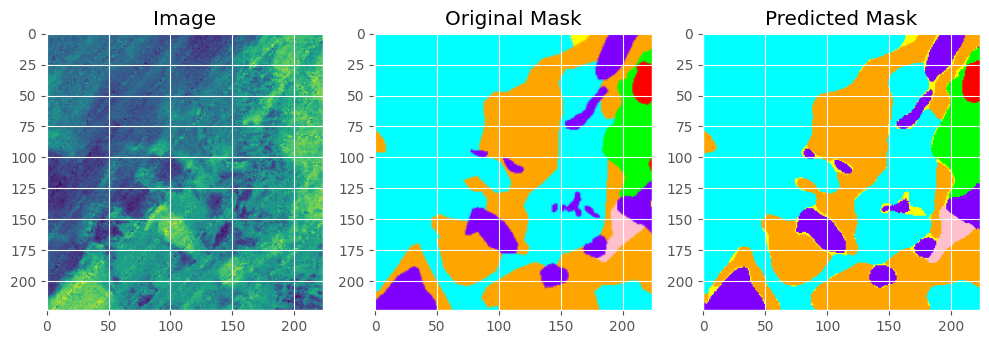

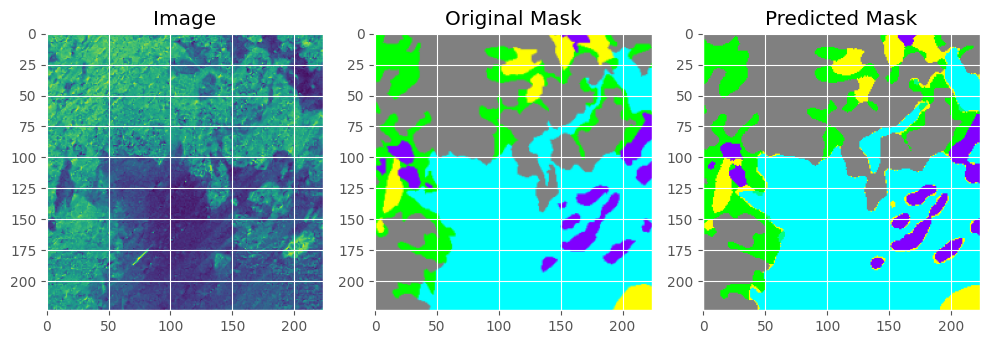

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
MODEL_PATH = '/content/drive/MyDrive/seafloor-best-noBG.pth'
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)

In [ ]:
def dice_coef(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [ ]:

def getPredMasks(model, imagePath):
  model.eval()
    # turn off gradient tracking
  with torch.no_grad():
      image= skimage.io.imread(imagePath)
      image = skimage.transform.resize(image,(INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT))

      orig = image
      orig = np.swapaxes(orig,0,2)
      image = ToTensor()(image)
      image[0] = (image[0]/255)
      image[1] = ((image[1] - 23.580292) / (-88.83606719970703 - 23.580292))
      three_chan_image = torch.stack((image[0],image[1],image[2]))


      filename = imagePath.split(os.path.sep)[-1]
      gtFilename = filename.replace(".tif",'.png')
      groundTruthPath = os.path.join(MASK_DATASET_PATH,
        gtFilename)


      gtMask = torchvision.io.read_image(groundTruthPath)
      gtMask = torchvision.transforms.Resize((INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT))(gtMask)


      three_chan_image = (three_chan_image).unsqueeze(0).to(DEVICE)


      predMask = model(three_chan_image).squeeze()

      predMask = torch.nn.functional.softmax(predMask,dim=0)
      predMask = predMask.argmax(dim=0)
      predMask = predMask.cpu().numpy()

      predMask = voc_label_to_rgb(predMask, VOC_COLORMAP)
      gtMask = np.swapaxes(gtMask,0,2)
      predMask = predMask.astype(np.uint8)

      return predMask,gtMask

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/seafloor-best-noBG.pth'
print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
average_dice = 0
for image in tqdm(imagePaths):
  pred,gt = getPredMasks(unet,image)
  pred = np.array(pred)
  gt = np.array(gt)
  average_dice += dice_coef(pred,gt)
print(average_dice/len(imagePaths))

[INFO] loading up test image paths...
[INFO] load up model...


100%|██████████| 896/896 [22:30<00:00,  1.51s/it]

7.192208343574362e-05


In [ ]:

avg_iou = 0
for image in tqdm(imagePaths):
  prediction, target = getPredMasks(unet,image)
  prediction = np.array(prediction)
  target = np.array(target)
  intersection = np.logical_and(target, prediction)
  union = np.logical_or(target, prediction)
  iou_score = np.sum(intersection) / np.sum(union)
  avg_iou += iou_score
print(avg_iou/len(imagePaths))

100%|██████████| 896/896 [00:39<00:00, 22.69it/s]

0.7402358461240505
